The same idea as in the Notebook 6, but with a more efficient model architecture: https://huggingface.co/docs/transformers/v4.26.1/en/model_doc/reformer

# 1. Data

## 1. 1. Load the parallel text

In [1]:
import pandas as pd
from tqdm.auto import tqdm, trange
from sklearn.model_selection import train_test_split
import torch
from datasets import load_dataset
import gc
import numpy as np
import random

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

In [2]:
df_orig = pd.read_csv('../data/spellchecker_dataset_split.tsv', sep='\t')
df_orig

,trash,clean,trash2,clean2,distance,normalized_distance,split,edit_max_cldiff,edit_max_lendiff
0,"Шунда ук әсәйемдең тоҡсайын, төйөнсөктәрен күҙ...","Шунда уҡ әсәйемдең тоҡсайын, төйөнсөктәрен күҙ...","Шунда ук әсәйемдең тоҡсайын, төйөнсөктәрен күҙ...","Шунда уҡ әсәйемдең тоҡсайын, төйөнсөктәрен күҙ...",1,0.015385,train,1,0
1,Унан беҙ өсөбөҙ ҙә ултырғыстарға ултырабыҙ.,Унан беҙ әсәбеҙ ҙә ултырғыстарға ултырабыҙ.,Унан беҙ өсөбөҙ ҙә ултырғыстарға ултырабыҙ.,Унан беҙ әсәбеҙ ҙә ултырғыстарға ултырабыҙ.,3,0.069767,test,1,0
2,"«Иҫән-Һау ғына тороғоҙ инде», - тип бышылдай у...","«Иҫән-һау ғына тороғоҙ инде», - тип бышылдай у...","«Иҫән-Һау ғына тороғоҙ инде», - тип бышылдай у...","«Иҫән-һау ғына тороғоҙ инде», - тип бышылдай у...",1,0.014085,dev,1,0
3,"Минең генә бер кешем дә юҡ, тип шунда уҡ танау...","Минең генә бер кешем дә юҡ, - тип шунда уҡ тан...","Минең генә бер кешем дә юҡ, тип шунда уҡ танау...","Минең генә бер кешем дә юҡ, - тип шунда уҡ тан...",2,0.029412,train,0,0
4,"Ай йөрөгән, ти, йыл йөрөгән, ти, батыр, ете та...","Ай йөрөгән, ти, йыл йөрөгән, ти, батыр, ете та...","Ай йөрөгән, ти, йыл йөрөгән, ти, батыр, ете та...","Ай йөрөгән, ти, йыл йөрөгән, ти, батыр, ете та...",1,0.012500,train,1,0
...,...,...,...,...,...,...,...,...,...
23886,"Эҫтәрендә бүре үк оломаһа ла, эттәр шыңшый баш...","Эстәрендә бүре үк оломаһа ла, эттәр шыңшый баш...","Эҫтәрендә бүре үк оломаһа ла, эттәр шыңшый баш...","Эстәрендә бүре үк оломаһа ла, эттәр шыңшый баш...",1,0.020000,dev,1,0
23887,Үткән йәйҙә яман томра көндө Кәҙерғол төбәгенд...,Үткән йәйҙә яман томра көндө Ҡәҙерғол төбәгенд...,Үткән йәйҙә яман томра көндө Кәҙерғол төбәгенд...,Үткән йәйҙә яман томра көндө Ҡәҙерғол төбәгенд...,1,0.009524,train,1,0
23888,"Кайтыр алдынан салбарҙы эҙләй башлаһа, таба ал...","Ҡайтыр алдынан салбарҙы эҙләй башлаһа, таба ал...","Кайтыр алдынан салбарҙы эҙләй башлаһа, таба ал...","Ҡайтыр алдынан салбарҙы эҙләй башлаһа, таба ал...",1,0.020000,train,1,0
23889,Кыш урталарында бер көн Әбдрәшит ат аҙбарынан ...,Ҡыш урталарында бер көн Әбдрәшит ат аҙбарынан ...,Кыш урталарында бер көн Әбдрәшит ат аҙбарынан ...,Ҡыш урталарында бер көн Әбдрәшит ат аҙбарынан ...,1,0.009174,train,1,0


In [3]:
df_orig_train = df_orig[(df_orig.split=='train')]
print(df_orig_train.shape)

df_orig_train = df_orig_train[df_orig_train.edit_max_cldiff <= 3]
print(df_orig_train.shape)
df_orig_train = df_orig_train[df_orig_train.edit_max_lendiff <= 1].copy()
print(df_orig_train.shape)

(14382, 9)
(14171, 9)
(14085, 9)


In [4]:
df_orig_dev = df_orig[(df_orig.split=='dev') & (df_orig.edit_max_cldiff <= 3) & (df_orig.edit_max_lendiff <= 1)]
print(df_orig_dev.shape)
dev_small = df_orig_dev.sample(100, random_state=1).copy()

(4611, 9)


## 1.2. Corrupt the clean sents

In [5]:
with open('../data/clean_bk_sents.txt', 'r') as f:
    cs2 = [line.strip() for line in f]
print(len(cs2))

1605495


In [6]:
all_chars = ''.join(sorted({
    c for texts in [cs2, df_orig_train.trash, df_orig_train.clean] 
    for text in texts for c in text
}))
print(all_chars)
print(len(all_chars))

all_chars = ''.join(sorted(set(all_chars + all_chars.upper() + all_chars.lower())))
print(all_chars)
print(len(all_chars))

	 !"#%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¢¦§ª«¬­®°²µ·»¿ÀÁÂÄÉÊÌÍÎÐÒÖ×ØÜÝÞàáâãäåçèéêëìíîïðñòóôõö÷øûüýÿāČčğıłŠšūŽžƏəɵʺ̶́ΒΠΧЁЃЄЅІЉЋЏАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяёђѓєѕіїљњћќўџѲѳҐҒғҖҗҘҙқҠҡҢңҪҫҮүҰҺһӊӘәӧӨөاتخرسعكنو  ​‎‐‑‒–—―‘’“”„•… ‰›⁠№Ⅰ→∂−≥⏰─●☎⚡✒✓✨﻿🌸🎭📝
354
	 !"#%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¢¦§ª«¬­®°²µ·»¿ÀÁÂÃÄÅÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÛÜÝÞàáâãäåçèéêëìíîïðñòóôõö÷øûüýþÿĀāČčĞğıŁłŠšŪūŸŽžƏƟəɵʺ̶́ΒΜΠΧβπχЁЂЃЄЅІЇЉЊЋЌЎЏАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяёђѓєѕіїљњћќўџѲѳҐґҒғҖҗҘҙҚқҠҡҢңҪҫҮүҰұҺһӉӊӘәӦӧӨөاتخرسعكنو  ​‎‐‑‒–—―‘’“”„•… ‰›⁠№Ⅰⅰ→∂−≥⏰─●☎⚡✒✓✨﻿🌸🎭📝
387


In [7]:
from noisers import add_simple_noise
from noisers import Noiser

In [8]:
noiser = Noiser.load('noise_model_v1.json')

In [9]:
text = random.choice(cs2)
text

'Ә-ә, уларҙа тормош икенсе, тәр\xadбиә башҡа төрлө, тиһеңме?'

In [10]:
add_simple_noise(text, all_chars)

'Ә-ә, уларҙа тормош икенсÂе, әр\xadбиә бɵшҡа төрлө, тиһеJме?'

In [11]:
noiser.add_noise(text)

'Ә-* ә, уларҙа тормош икенсе, тәр\xadбиә башҡа төрлө, тиһеңме?'

# 2. Building the model

In [12]:
VOCAB = ['▁', '[pad]', '[unk]', '[cls]', '[sep]', '[mask]', '[bos]', '[eos]'] + list(all_chars)
print(len(VOCAB))

395


In [13]:
with open('char_vocab.txt', 'w') as f:
    for t in VOCAB:
        print(t, file=f)

In [14]:
import char_tokenizer
from importlib import reload
reload(char_tokenizer)
from char_tokenizer import CharTokenizer

In [15]:
tokenizer = CharTokenizer(vocab_file='char_vocab.txt', model_max_length=4092)

In [16]:
# from transformers import BertConfig, BertForMaskedLM
#from transformers import ReformerConfig, ReformerForMaskedLM  # they don't work, sorry
from transformers import LongformerConfig, LongformerForMaskedLM

In [17]:
model_cfg = LongformerConfig(
    attention_window = 128,
    sep_token_id = tokenizer.sep_token_id,
    pad_token_id = tokenizer.pad_token_id,
    bos_token_id = tokenizer.bos_token_id,
    eos_token_id = tokenizer.eos_token_id,
    vocab_size = len(tokenizer),
    hidden_size=256,
    num_hidden_layers=4,
    num_attention_heads=8,
    intermediate_size=512,
    hidden_act="gelu",
    max_position_embeddings = 4096,
    position_embedding_type = "relative_key_query",
)

In [19]:
model_cfg.max_position_embeddings

4096

In [20]:
model = LongformerForMaskedLM(model_cfg)

In [21]:
MODEL_NAME = '../models/longformer-char-ctc-bak-denoise'

In [22]:
model.save_pretrained(MODEL_NAME)
tokenizer.save_pretrained(MODEL_NAME)

('../models/longformer-char-ctc-bak-denoise\\tokenizer_config.json',
 '../models/longformer-char-ctc-bak-denoise\\special_tokens_map.json',
 '../models/longformer-char-ctc-bak-denoise\\vocab.txt',
 '../models/longformer-char-ctc-bak-denoise\\added_tokens.json')

# 3. Training loop

In [23]:
model.cuda();

In [24]:
model.train();

In [25]:
import textdistance

def fix_text(text, verbose=False, spaces=2):
    with torch.inference_mode():
        batch = tokenizer(text, return_tensors='pt', spaces=spaces, padding=True, truncation=True, return_token_type_ids=False).to(model.device)
        logits = torch.log_softmax(model(**batch).logits, axis=-1)
    return tokenizer.decode(logits[0].argmax(-1), skip_special_tokens=True)

In [26]:
def eval_model(spaces=1):
    dev_small['fixed'] = [fix_text(text, spaces=spaces) for text in dev_small.trash2]
    dev_small['change_amount'] = dev_small.apply(lambda row: textdistance.levenshtein.distance(row.trash2, row.fixed), axis=1)
    dev_small['new_diff'] = dev_small.apply(lambda row: textdistance.levenshtein.distance(row.clean2, row.fixed), axis=1)
    return 1 - dev_small.new_diff.sum() / dev_small.distance.sum()

In [27]:
eval_model()

-143.32558139534885

In [28]:
from torch.optim import AdamW
optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad], 
    lr=1e-4,
    weight_decay=1e-2,
)
cleanup()

In [29]:
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=1000)

In [30]:
ewm_loss = 0
losses = []

In [31]:
batch_size = 4  # Using a longformer architecture instead of just BERT, allows us increasing the batch size from 3 to 8 w/o OOM

share_real = 0.1
share_noiser = 0.4
p_keep = 0.2

report_steps = 1000  
cleanup_steps = 100  

gradient_steps = 1
window = 1000

In [124]:
loss, logits, batch, batch_labels = None, None, None, None
cleanup()
model.train()

tq = trange(len(losses), 600_000)
for i in tq:
    r = random.random()
    if r < share_real:
        batch = df_orig_train.sample(batch_size)
        xx, yy = batch.trash2.tolist(), batch.clean2.tolist()
    elif r < share_real + share_noiser:
        yy = random.sample(cs2, batch_size)
        xx = [noiser.add_noise(text, edit_rate=0.05) if random.random() > p_keep else text for text in yy]
    else:
        yy = random.sample(cs2, batch_size)
        xx = [add_simple_noise(text, all_chars, edit_rate=0.05) if random.random() > p_keep else text for text in yy]
    
    random_spaces = random.choices([0, 1, 2], weights=[0.1, 0.7, 0.2])[0]
    batch = tokenizer(xx, return_tensors='pt', spaces=random_spaces, padding=True, truncation=True).to(model.device)
    batch_labels = tokenizer(yy, return_tensors='pt', spaces=0, padding=True, truncation=True, add_special_tokens=False).to(model.device)

    try:
        logits = torch.log_softmax(model(**batch).logits, axis=-1)
        loss = torch.nn.functional.ctc_loss(
            logits.transpose(1, 0), 
            batch_labels.input_ids, 
            batch.attention_mask.sum(1), 
            batch_labels.attention_mask.sum(1), 
            reduction='mean',
            zero_infinity=True,
        )
        loss.backward()

        if i % gradient_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
    except RuntimeError as e:
        if 'out of memory' not in str(e):
            raise e
        print(
            'error', i, 
            'sizes:', batch['input_ids'].shape, max(len(_) for _ in xx), 
            '/', batch_labels['input_ids'].shape, max(len(_) for _ in yy), 
            e
        )
        # raise e
        loss, logits, batch, batch_labels = None, None, None, None
        optimizer.zero_grad(set_to_none=True)
        cleanup()
        continue

    w = 1 / max(1, min(len(losses), window))
    ewm_loss = ewm_loss * (1-w) + loss.item() * w
    losses.append(loss.item())
    tq.set_description(f'{ewm_loss:3.3f}')

    if len(losses) % report_steps == 0:
        model.eval();
        print('step', len(losses), 'loss', np.mean(losses[-report_steps:]), 'error decrease', eval_model())
        model.train();
        if i > 0:
            print('SAVING')
            model.save_pretrained(MODEL_NAME)
            tokenizer.save_pretrained(MODEL_NAME)
    if i % cleanup_steps == 0:
        cleanup()
    # implement a very late learning rate cooldown
    if i >= 460_000:
        optimizer.param_groups[0]['lr'] = 1e-4 * (600_000 - i) / (600_000 - 460_000)

  0%|          | 0/48288 [00:00<?, ?it/s]

step 552000 loss 0.11332793859299273 error decrease 0.49612403100775193
SAVING
error 552279 sizes: torch.Size([4, 4092]) 5612 / torch.Size([4, 4092]) 5617 CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 4.00 GiB total capacity; 2.02 GiB already allocated; 432.20 MiB free; 2.22 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
step 553000 loss 0.10836573872971349 error decrease 0.4418604651162791
SAVING
error 553857 sizes: torch.Size([4, 4092]) 1689 / torch.Size([4, 1681]) 1681 CUDA out of memory. Tried to allocate 210.00 MiB (GPU 0; 4.00 GiB total capacity; 2.22 GiB already allocated; 170.20 MiB free; 2.48 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
step 554000 loss 0.1144480233

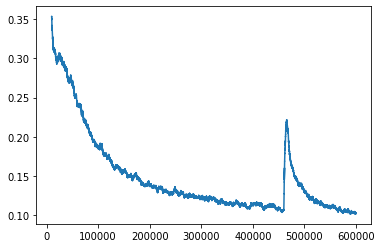

In [125]:

# step 149000 loss 0.14386079168878496 error decrease 0.3875968992248062
# At 460000 steps I accidentially broke the model, by using a x10 larger learning rate than I should have.
pd.Series(losses).ewm(3000).mean()[10_000:].plot();

In [ ]:
batch = tokenizer(xx, return_tensors='pt', spaces=random_spaces, padding=True, truncation=True)

In [ ]:
batch.attention_mask

In [ ]:
is_index_global_attn = batch.attention_mask > 0
is_global_attn = is_index_global_attn.flatten().any().item()

In [ ]:
is_global_attn

In [ ]:
batch.input_ids.shape

In [ ]:
batch.

In [ ]:
loss, logits, batch, batch_labels = None, None, None, None
optimizer.zero_grad(set_to_none=True)
cleanup()

In [ ]:
fix_text(text)

In [130]:
model.eval();

In [131]:
dev_small['fixed'] = [fix_text(text, 1) for text in tqdm(dev_small.trash2)]

  0%|          | 0/100 [00:00<?, ?it/s]

In [132]:
dev_small['change_amount'] = dev_small.apply(lambda row: textdistance.levenshtein.distance(row.trash2, row.fixed), axis=1)
dev_small['new_diff'] = dev_small.apply(lambda row: textdistance.levenshtein.distance(row.clean2, row.fixed), axis=1)

In [133]:
dev_small.mean()

distance               1.2900
normalized_distance    0.0175
edit_max_cldiff        0.4600
edit_max_lendiff       0.0300
change_amount          0.8800
new_diff               0.6300
dtype: float64

In [134]:
1 - dev_small.new_diff.sum() / dev_small.distance.sum()

0.5116279069767442

In the end, the gains seem to be not as good as with a normal BERT

In [135]:
for s in range(3):
    print(eval_model(spaces=s))

-0.49612403100775193
0.49612403100775193
0.5116279069767442


In [136]:
text

'Ә-ә, уларҙа тормош икенсе, тәр\xadбиә башҡа төрлө, тиһеңме?'

In [137]:
batch = tokenizer(text, return_tensors='pt', spaces=random_spaces, padding=True, truncation=True).to(model.device)
with torch.no_grad():
    logits = torch.log_softmax(model(**batch).logits, axis=-1).detach()

In [138]:
print(logits.shape)

torch.Size([1, 115, 395])


This beam decoder works, but it is slow as fuck 

In [139]:
from collections import defaultdict, Counter


def decode_ctc_beam(log_proba, num_beams=10, blank_id=0):
    """Compute the approximate top k hypoheses of CTC and their probabilities"""
    beams = [((), True, torch.tensor(0))]  # triplets of (prefix, is_open, sum_log_probs)
    for step in trange(log_proba.shape[0]):
        hyp2logscores = defaultdict(list)
        for token_id in range(log_proba.shape[1]):
            for (seq, is_open, score) in beams:
                new_score = score + log_proba[step, token_id]
                if token_id == blank_id:  # just add blank to the current sequence
                    hyp2logscores[(seq, False)].append(new_score)
                else:
                    if is_open and len(seq) > 0 and token_id == seq[-1]:  # continue the curent open sequence
                        hyp2logscores[(seq, True)].append(new_score)
                    else:
                        hyp2logscores[(seq + (token_id,), True)].append(new_score)
        scorer = Counter()
        for k, scores in hyp2logscores.items():
            scorer[k] = torch.logsumexp(torch.stack(scores), 0)
        beams = [(seq, is_open, score) for (seq, is_open), score in scorer.most_common(num_beams)]
    return beams

Speed up by moving into the probabilities space: better, but still fuking slow

In [140]:
def decode_ctc_beam(log_proba, num_beams=10, blank_id=0):
    """Compute the approximate top k hypoheses of CTC and their probabilities"""
    beams = [((), True, torch.tensor(1))]  # triplets of (prefix, is_open, sum_log_probs)
    proba = torch.softmax(log_proba, -1)
    for step in trange(log_proba.shape[0]):
        scorer = Counter()
        for token_id in range(log_proba.shape[1]):
            for (seq, is_open, score) in beams:
                new_score = score * proba[step, token_id]
                if token_id == blank_id:  # just add blank to the current sequence
                    scorer[(seq, False)] += new_score
                else:
                    if is_open and len(seq) > 0 and token_id == seq[-1]:  # continue the curent open sequence
                        scorer[(seq, True)] += new_score
                    else:
                        scorer[(seq + (token_id,), True)] += new_score
        beams = [(seq, is_open, score) for (seq, is_open), score in scorer.most_common(num_beams)]
    return beams

In [160]:
def decode_ctc_beam(log_proba, num_beams=10, n2=11, blank_id=0):
    """Compute the approximate top k hypoheses of CTC and their probabilities"""
    beams = [((), True, torch.tensor(1))]  # triplets of (prefix, is_open, sum_log_probs)
    proba = torch.softmax(log_proba, -1)
    for step in range(log_proba.shape[0]):
        scorer = Counter()
        _, indices = torch.topk(proba[step], n2)
        for token_id in indices.cpu().numpy():
            for (seq, is_open, score) in beams:
                new_score = score * proba[step, token_id]
                if token_id == blank_id:  # just add blank to the current sequence
                    scorer[(seq, False)] += new_score
                else:
                    if is_open and len(seq) > 0 and token_id == seq[-1]:  # continue the curent open sequence
                        scorer[(seq, True)] += new_score
                    else:
                        scorer[(seq + (token_id,), True)] += new_score
        beams = [(seq, is_open, score) for (seq, is_open), score in scorer.most_common(num_beams)]
    return [(seq, score.item()) for (seq, is_open, score) in beams]

In [161]:
beams = decode_ctc_beam(logits[0], n2=20)
for hyp, score in beams[:5]:
    print(score, ''.join(tokenizer.convert_ids_to_tokens(hyp)))

0.832899808883667 Ә-ә, уларҙа тормош икенсе, тәр­биә башҡа төрлө, тиһеңме?
0.035917624831199646 Ә-ә, уларҙа тормош икенсе, тәр­биә башҡа төрлө, - тиһеңме?
0.007658788003027439 Ә ә, уларҙа тормош икенсе, тәр­биә башҡа төрлө, тиһеңме?
0.005061058793216944 Ә-ә, улар ҙа тормош икенсе, тәр­биә башҡа төрлө, тиһеңме?
0.003933039028197527 Ә-ә, уларҙа тормош икенсе, тәр­биә башҡа төрлө тиһеңме?


In [165]:
beams = decode_ctc_beam(logits[0], num_beams=5, n2=5)
for hyp, score in beams[:5]:
    print(score, ''.join(tokenizer.convert_ids_to_tokens(hyp)))

0.8234241008758545 Ә-ә, уларҙа тормош икенсе, тәр­биә башҡа төрлө, тиһеңме?
0.03550899028778076 Ә-ә, уларҙа тормош икенсе, тәр­биә башҡа төрлө, - тиһеңме?
0.0038908934220671654 Ә-ә, уларҙа тормош икенсе, тәр­биә башҡа төрлө тиһеңме?
0.0016263878205791116 Ә-ә, уларҙа тормош икенсе, тәр­биә башҡа төрлө, тиһеңме.
0.001475932658649981 Ә-ә, уларҙа тормош икенсе, тәр­биә башҡа төрлө, тиhеңме?


In [166]:
def fix_text_beam(text, verbose=False, spaces=1, num_beams=5, num_top=5):
    with torch.inference_mode():
        batch = tokenizer(text, return_tensors='pt', spaces=spaces, padding=True, truncation=True, return_token_type_ids=False).to(model.device)
        logits = torch.log_softmax(model(**batch).logits, axis=-1)
    if num_beams <= 1:
        return tokenizer.decode(logits[0].argmax(-1), skip_special_tokens=True)
    hyps = decode_ctc_beam(logits[0], num_beams=num_beams, n2=num_top)
    return tokenizer.decode(hyps[0][0], skip_special_tokens=True)

In [188]:
dev_small['fixed'] = [fix_text_beam(text, spaces=1, num_beams=5, num_top=3) for text in tqdm(dev_small.trash2)]

  0%|          | 0/100 [00:00<?, ?it/s]

In [189]:
dev_small['change_amount'] = dev_small.apply(lambda row: textdistance.levenshtein.distance(row.trash2, row.fixed), axis=1)
dev_small['new_diff'] = dev_small.apply(lambda row: textdistance.levenshtein.distance(row.clean2, row.fixed), axis=1)

In [190]:
dev_small.mean()

distance               1.2900
normalized_distance    0.0175
edit_max_cldiff        0.4600
edit_max_lendiff       0.0300
change_amount          1.6600
new_diff               1.3500
dtype: float64

In [191]:
1 - dev_small.new_diff.sum() / dev_small.distance.sum()

-0.04651162790697683

In [192]:
dev_small['fixed']

19699                                                                                                                                                  Делагоа ҡултығында.
965                                                            Диуарҙар буйлап бер өҫкә, бер аҫҡа күсеп, иң өҫкө ҡатарҙағы өй эстәрен, залдарҙы, сарҙаҡтарҙы ҡарап сыҡтым.
13577                                                                                                            Үҙ-ара сәңгелдәшеп: - Йөрөй шунда, ҡартайғанда тыртайған!
12487                                                                                                                                            Ҡорбанғәле, һиңә әйтәмсе.
20720                                                                     Ошо һүҙән һуң уның тауышы өҙөлдө, һәм ул, нисек торһа - шул килеш, бөтә аяҡтары менән ергә ауҙы.
                                                                                       ...                                                       

In [193]:
pd.options.display.max_colwidth = 200

In [212]:
dev_small[['clean2', 'fixed', 'new_diff']].sample(3)

,clean2,fixed,new_diff
15073,Улар башлыса Урал аръяғында күбәйә барған иген игеүсе ауылдарҙан йыйылғайны. ...Төлкөсура үҙенә йылғаны ҡайҙан кисеү кәрәклеген күрһәткән билдәләрҙе алыҫтан уҡ абайлап килде.,Улар башлыса Урал аръяғында күбәйә барған иген итеүсе ауылдарҙан йыйылғайны. .Төлкөсура үҙенә йылғаны ҡайҙан кисеү кәрәклеген күрһәткән билдәләрҙе алыҫтан уҡ абайлап килде.,3
23813,"Ҡазаға тарыҡҡан ошо каруанға юл белеүсе бер юламан тап булып, уны һыу янына алып килгән, ти.","Казаға тарыҡан ошо каруанға юл белеүсе бер юламан тап булып, уны һыу янына алып килгән, ти.",2
15509,Быуа йылғаның һай ғына ситендә - ҡырсынлыҡта ине.,Быуа йылғаның һай ғына ситендә ҡырсынлыҡта ине.,2


In [177]:
text = 'Уны алып барып ҡушҡан кешеләр төркөмөндә Герард-туған да бар ине, ул инде барыһын һорашып-белеп өлгөргәйне.'

In [180]:
fix_text_beam(text, spaces=1, num_beams=1, num_top=1) == fix_text(text, spaces=1)

True

In [182]:
fix_text_beam(text, spaces=1, num_beams=1, num_top=1)

'Уны алып барып ҡушҡан кешеләр төркөмөндә Герард-туған да бар ине, ул инде барыһын һорашып-белеп өлгөргәйне.'

In [187]:
fix_text_beam(text, spaces=1, num_beams=5, num_top=5)

'Уны алып барып ҡушҡан кешеләр төркөмөндә Герард-туған да бар ине, ул инде барыһын һорашып-белеп өлгөргәйне.'